In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import gensim 
from gensim.models import Word2Vec 
from gensim.models.keyedvectors import KeyedVectors

### Define the data_directory of preprocessed data and load the directory of the pretrained word2vec dictionary 

In [2]:
data_directory = "C:/Users/kwokp/OneDrive/Desktop/Study/zzz_application project/Final/data_after_preprocessing.csv"
model = KeyedVectors.load_word2vec_format('C:/Users/kwokp/OneDrive/Desktop/Study/zzz_application project/Final/GoogleNews-vectors-negative300.bin', binary=True)

### We devide the data into 3 groups:
* Group 1: full data
* Group 2: data with four large categories which have more than 1000 companies each
* Group 3: seven categories of data, number of companies in each category is same but small

### In the function selectGroup, giving 1, 2 or 3 as input parameter to selet the relevant data for experiment

In [3]:
# read the data from directory, then select the group 
# of data we want to process.
def selectGroup(directory, group_nr):
    data = pd.read_csv(directory, sep='\t')
    if group_nr == 1:
        return data
    if group_nr == 2:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=1041,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=1041,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=1041,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=1041,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group])
        return df_clean.sample(frac=1)
    if group_nr == 3:
        df_healthcare_group=data[data['Category'] == 'HEALTHCARE GROUP'].sample(n=219,replace=False)
        df_business_financial_services=data[data['Category'] == 'BUSINESS & FINANCIAL SERVICES'].sample(n=219,replace=False)
        df_consumer_service_group=data[data['Category'] == 'CONSUMER SERVICES GROUP'].sample(n=219,replace=False)
        df_information_technology_group=data[data['Category'] == 'INFORMATION TECHNOLOGY GROUP'].sample(n=219,replace=False)
        df_industry_goods=data[data['Category'] == 'INDUSTRIAL GOODS & MATERIALS GROUP'].sample(n=219,replace=False)
        df_consumer_goods=data[data['Category'] == 'CONSUMER GOODS GROUP'].sample(n=219,replace=False)
        df_energy=data[data['Category'] == 'ENERGY & UTILITIES GROUP'].sample(n=219,replace=False)
        df_clean = pd.concat([df_healthcare_group, df_business_financial_services,df_consumer_service_group,df_information_technology_group,df_industry_goods,df_consumer_goods,df_energy])
        return df_clean.sample(frac=1)

In [4]:
# use tf-idf methode to generate scores for each company
def tf_idf_func(df_document, max_features):
    feature_extraction = TfidfVectorizer(max_features = max_features, stop_words = 'english')
    score_matrix = feature_extraction.fit_transform(df_document.values)
    return score_matrix, feature_extraction

In [5]:
# get the top_n words with highest tf-idf scores in each category, and count the word occurence
def get_top_keywords_with_frequence(Top_N, score_matrix, df_data, feature_extraction):
    df = pd.DataFrame(score_matrix.todense()) #read tf-idf score-matrix, each line is vectors for each company, each column matches each word
    df['Category'] = df_data['Category'] #assign the category for each line(company) in score-matrix
    dfg = df.groupby(['Category']).mean() #calculate the mean score of each word in each cateogry

    labels = feature_extraction.get_feature_names()

    categories = df_data['Category'].unique()
    col_names = ['Category', 'Top_N', 'Score']
    df_top = pd.DataFrame(columns = col_names)

    Dict = {}

    for i,r in dfg.iterrows(): #i-index(category), r-row, iterate the average score matrix of each category
        category = i 
        top_series = np.argsort(r)[-Top_N:]#find the location of top_n words
        label_series = top_series.apply(lambda x: labels[x]) #find top_n words with best scores in each category
        top_scores = np.sort(r)[-Top_N:] #find the scores corresponding with top_n words
        df_each = pd.DataFrame({'Category':category,'Top_N':label_series,'Score':top_scores})
        df_top = df_top.append(df_each, ignore_index = True)
        for key in label_series: #count how often each word appears in the top_n
            if key in Dict:
                Dict[key] = Dict[key]+1
            else:
                Dict[key] = 1
    
    df_reshape = df_top.pivot(index='Top_N', columns='Category') #reformat the top-n score matrix
    sortedDict = sorted(Dict.items(), key=lambda x: x[1]) #sort the dictionary
    
    return sortedDict

In [6]:
# convert the input of the top_n words with their occurence in each category, to a list of stopwords, 
# if the occurence is larger than the given occurence
def get_word_occurence_stopwordslist(max_occurence, dict_list):
    word = []
    occurence = []
    frequent_stopwords = []
    for key, value in dict_list:
        word.append(key)
        occurence.append(value)
        if value > max_occurence: # if the occurence is larger than the given occurence
            frequent_stopwords.append(key) # store to a list of stopwords
    return frequent_stopwords

In [7]:
#remove the words from a sentence, which is in the stopwords
def remove_frequent_stopwords(sentences, frequent_stopwords):
    splitted_string = sentences.split()
    remove_stopwords = [w for w in splitted_string if not w in frequent_stopwords]
    return ' '.join(remove_stopwords)

#remove the words from the website content, which is in the stopwords
#update the tf-idf score matrix for the whole corpus
def remove_frequent_stopwords_and_get_updated_tfidfscore(data, feature_extraction, top_n, frequent_stopwords):
    df_update = data['clean'].apply(lambda x: remove_frequent_stopwords(x, frequent_stopwords))
    score_matrix_update = feature_extraction.fit_transform(df_update.values)
    return score_matrix_update

### We first remove the stopwords which appears in multiple category and generate the dateframe for word2vec. Main steps are as follows:
1. select the group of data to do the test
2. generate TF-IDF score matrix
3. get the top 50 words in each category
4. find the words which appears in more than one category's top-50 words, set them as stopwords
5. remove these stopwords and update the tf-idf score matrix
6. count and calculate the word occurences in each company's website
7. plot the number of valid words in each website
8. remove the website which has less than 200 words
9. generate the new dataframe for word2vec

### We may notice there are quite a few companies which has less than 200 words. These websites could be useless. And the category distrubtion after processing is shown as the reuslt of the cell.

INFORMATION TECHNOLOGY GROUP          1503
BUSINESS & FINANCIAL SERVICES         1333
CONSUMER SERVICES GROUP                956
HEALTHCARE GROUP                       832
INDUSTRIAL GOODS & MATERIALS GROUP     391
CONSUMER GOODS GROUP                   341
ENERGY & UTILITIES GROUP               175
Name: Category, dtype: int64

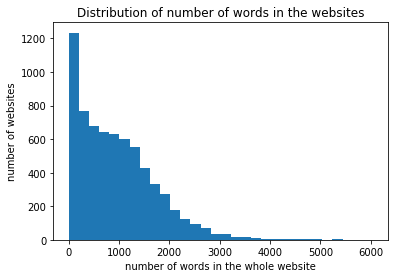

In [8]:
#get the data, remove the frequent words which appear in more than one category, and update the tf-idf score matrix
data = selectGroup(data_directory, 1)
score_matrix, feature_extraction = tf_idf_func(data['clean'], 8000)
sortedDict = get_top_keywords_with_frequence(50, score_matrix, data, feature_extraction)
frequent_stopwords = get_word_occurence_stopwordslist(1, sortedDict)
score_matrix_update = remove_frequent_stopwords_and_get_updated_tfidfscore(data, feature_extraction, 10, frequent_stopwords)

# count the non-zero words from updated tf-idf score matrix and display the non-zero word count in each company website
score_value = score_matrix_update.todense()
website_word_count=np.asarray(np.count_nonzero(score_value, axis=1)).reshape(-1)
plt.hist(website_word_count, bins = 30)
plt.xlabel('number of words in the whole website')
plt.ylabel('number of websites')
plt.title('Distribution of number of words in the websites')

df_score=pd.DataFrame(score_value)
df_score.columns=feature_extraction.get_feature_names()
df_score['Keep']=website_word_count>200
df_score['Category'] = data['Category'].reset_index(drop=True)
df_score_valid = df_score[df_score['Keep']]
df_score_valid['Category'].value_counts()

### Choose 100 words which have the highest tf-idf scores in each webstie

In [9]:
df_final = df_score_valid[df_score_valid.columns.difference(['Keep', 'Category'])] #remove columns'Keep' and 'Category'
top_n = 100
df_top_N = pd.DataFrame({n: df_final.T[col].nlargest(top_n).index.tolist() 
                  for n, col in enumerate(df_final.T)}).T
df_top_N

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,therapeutics,cd,dr,clinical,immune,cancer,ph,cells,antibodies,university,...,presentation,michael,javascript,therapeutic,life,positions,hong,clinic,san,demonstrating
1,hood,renewable,world,communities,exit,payments,charity,bills,receive,supply,...,direct,lake,equally,extreme,africa,conditions,discount,tough,end,homes
2,brown,trim,di,machine,la,sheet,series,en,und,tooling,...,plates,al,vos,specialty,manufacturing,automotive,si,material,linear,eine
3,kaltura,video,media,experience,tv,websites,learn,owner,player,join,...,different,certain,communication,requests,adoption,regarding,explore,edit,classroom,viewer
4,breast,cancer,radiation,marker,surgery,surgical,treatment,tissue,surgeon,surgeons,...,mj,experience,inventor,hall,calif,course,provides,area,usa,science
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,touch,projected,sensors,glass,plc,signage,sensor,sensing,displays,self,...,conditions,individuals,size,years,highly,england,asia,hi,global,aim
5527,schools,var,public,park,usd,dakota,place,theme,families,inclusive,...,catalog,ohio,guests,world,jersey,international,administrators,columbia,illinois,georgia
5528,interactive,retail,table,wall,tables,signage,sap,charlotte,store,digital,...,allowing,shop,videos,managers,associates,holds,cms,tank,february,december
5529,risk,alerts,est,research,agree,sample,member,wall,archive,keith,...,sectors,markets,short,address,notice,errors,covering,hockey,bound,donald


In [10]:
#convert the top-100 high score words to vectors of 300 components using the word2vec model
def get_vector_from_df(df):
    x_df = df[df.columns.difference(['Category'])]
    x_word = x_df.to_numpy()
    x = np.zeros([len(x_word), 300])
    for i in range(len(x_word)):
        initial_vector = np.zeros(300)
        unseen_word = 0
        for j in range(top_n):
            try:
                initial_vector = initial_vector + model.wv[x_word[i,j]] #use loaded tf-idf model 
            except KeyError as e:
                unseen_word = unseen_word + 1
        final_vector = initial_vector/(top_n-unseen_word)
        if np.isnan(np.sum(final_vector)):
            print(i)
            final_vector = np.zeros([1,300])
        x[i] = final_vector
    return x

df_category = df_score_valid['Category'].reset_index(drop=True)
df_top_N_v = get_vector_from_df(df_top_N)

C:\Users\kwokp\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()


### Compute Similarity between Categories and Plot Similarity Matrix

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
def average_similarity(cluster1, cluster2):
    sim = cosine_similarity(cluster1, cluster2)
    ave = sim.mean(1)
    cluster_similarity = ave.sum()/len(ave)
    return cluster_similarity

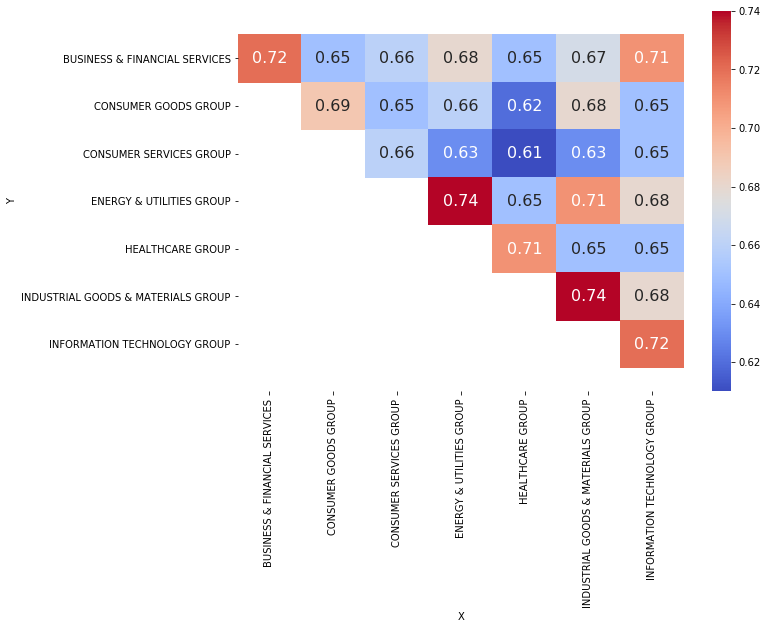

In [12]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings('ignore')

similarityArry=np.zeros([7,7])
categories = ['BUSINESS & FINANCIAL SERVICES', 'CONSUMER GOODS GROUP', 'CONSUMER SERVICES GROUP', 'ENERGY & UTILITIES GROUP', 'HEALTHCARE GROUP', 'INDUSTRIAL GOODS & MATERIALS GROUP', 'INFORMATION TECHNOLOGY GROUP'] 

for i in range(0,7,1):
    for j in range(0,7,1):
        indice1 = (df_category == categories[i]).to_numpy().nonzero()[0]
        indice2 = (df_category == categories[j]).to_numpy().nonzero()[0]
        cluster1 = df_top_N_v[indice1]
        cluster2 = df_top_N_v[indice2]
        similarityArry[i,j] =round(average_similarity(cluster1, cluster2),2)



array = similarityArry
y_true = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
y_pred = ["BUSINESS & FINANCIAL SERVICES","CONSUMER GOODS GROUP", "CONSUMER SERVICES GROUP","ENERGY & UTILITIES GROUP", "HEALTHCARE GROUP","INDUSTRIAL GOODS & MATERIALS GROUP", "INFORMATION TECHNOLOGY GROUP"]
df_cm = pd.DataFrame(array, y_true, y_pred)
df_cm.index.name = 'Y'
df_cm.columns.name = 'X'
plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)#for label size

mask = np.tri(array.shape[0], k=-1)
#mask[np.triu_indices_from(mask)] = True

ax=sn.heatmap(df_cm, mask=mask, cmap="coolwarm", annot=True,annot_kws={"size": 16})# font size
bottom, top=ax.get_ylim()
ax.set_ylim(bottom+0.5, top-0.5)
ax.tick_params(labelsize=10)
#ax.set_xticklabels(y_pred, rotation=45)
plt.show()